The following is an example of how to utilize our Sen1Floods11 dataset for training a FCNN. In this example, we train and validate on hand-labeled chips of flood events. However, our dataset includes several other options that are detailed in the README. To replace the dataset, as outlined further below, simply replace the train, test, and validation split csv's, and download the corresponding dataset.

Authenticate Google Cloud Platform. Note that to run this code, you must connect your notebook runtime to a GPU.

In [ ]:
from google.colab import auth
auth.authenticate_user()

!curl https://sdk.cloud.google.com | bash

!gcloud init

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-identity/2021-04-20/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-identity/2021-04-20/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-identity/2021-04-20/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-media-pipelines/2021-07-15/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-media-pipelines/2021-07-15/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-media-pipelines/2021-07-15/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-meetings/2021-07-15/endpoint-rule-set-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-meetings/2021-07-15/paginators-1.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-meetings/2021-07-15/service-2.json
google-cloud-sdk/lib/third_party/botocore/data/chime-sdk-mess

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0  13105      0 --:--:-- --:--:-- --:--:-- 13272
OK
49 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: http://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,418 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 123630 files and

Install RasterIO

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.9 MB/s eta 0:00:00


Define a model checkpoint folder, for storing network checkpoints during training

In [ ]:
%cd /home
!sudo mkdir checkpoints

/home


Download train, test, and validation splits for both flood water. To download different train, test, and validation splits, simply replace these paths with the path to a csv containing the desired splits.

In [ ]:
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv .
!gsutil cp gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv .

Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_train_data.csv...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_test_data.csv...
- [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      
Copying gs://sen1floods11/v1.1/splits/flood_handlabeled/flood_valid_data.csv...
- [1 files][  4.7 KiB/  4.7 KiB]                                                
Operation completed over 1 objects/4.7 KiB.                                      


Download raw train, test, and validation data. In this example, we are downloading train, test, and validation data of flood images which are hand labeled. However, you can simply replace these paths with whichever dataset you would like to use - further documentation of the Sen1Floods11 dataset and organization is available in the README.

In [ ]:
# Flag for whether or not to generate augmented features
augment_features_flag = True

# Additional flag for type of features to keep
# Options: "All", "HSV", "S1", "S1+AWEI+NDWI+HSV"
feature_set = "S1+AWEI+NDWI+HSV"

In [ ]:
!sudo mkdir files
!sudo mkdir files/Labels

# if run_S2_flag:
#   !sudo mkdir files/S2
#   !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand files/S2
# else:
#   !sudo mkdir files/S1
#   !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand files/S1

!sudo mkdir files/S2
!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S2Hand files/S2
!sudo mkdir files/S1
!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand files/S1

!gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled/LabelHand files/Labels

mkdir: cannot create directory ‘files’: File exists
mkdir: cannot create directory ‘files/Labels’: File exists
mkdir: cannot create directory ‘files/S2’: File exists

both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...

both the source and destination. Your crcmod installation isn't using the
module's C extension, so checksumming will run very slowly. If this is your
first rsync since updating gsutil, this rsync can take significantly longer than
usual. For help installing the extension, please see "gsutil help crcmod".

Building synchronization state...
Starting synchronization...
Copying gs://sen1floods11/v1.1/data/flood_events/HandLabeled/S1Hand/Bolivia_23014_S1Hand.tif..

Define model training hyperparameters

In [ ]:
LR = 5e-4
EPOCHS = 100
EPOCHS_PER_UPDATE = 1
RUNNAME = "Sen1Floods11"

Define functions to process and augment training and testing images

In [ ]:
import torch
from torchvision import transforms
import torchvision.transforms.functional as F
import random
from PIL import Image

class InMemoryDataset(torch.utils.data.Dataset):

  def __init__(self, data_list, preprocess_func):
    self.data_list = data_list
    self.preprocess_func = preprocess_func

  def __getitem__(self, i):
    return self.preprocess_func(self.data_list[i])

  def __len__(self):
    return len(self.data_list)


def processAndAugment(data):
  (x,y) = data
  im,label = x.copy(), y.copy()

  # convert to PIL for easier transforms
  im1 = Image.fromarray(im[0])
  im2 = Image.fromarray(im[1])
  label = Image.fromarray(label.squeeze())

  # Get params for random transforms
  i, j, h, w = transforms.RandomCrop.get_params(im1, (256, 256))

  im1 = F.crop(im1, i, j, h, w)
  im2 = F.crop(im2, i, j, h, w)
  label = F.crop(label, i, j, h, w)
  if random.random() > 0.5:
    im1 = F.hflip(im1)
    im2 = F.hflip(im2)
    label = F.hflip(label)
  if random.random() > 0.5:
    im1 = F.vflip(im1)
    im2 = F.vflip(im2)
    label = F.vflip(label)

  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])
  im = torch.stack([transforms.ToTensor()(im1).squeeze(), transforms.ToTensor()(im2).squeeze()])
  im = norm(im)
  label = transforms.ToTensor()(label).squeeze()
  if torch.sum(label.gt(.003) * label.lt(.004)):
    label *= 255
  label = label.round()

  return im, label


def processTestIm(data):
  (x,y) = data
  im,label = x.copy(), y.copy()
  norm = transforms.Normalize([0.6851, 0.5235], [0.0820, 0.1102])

  # convert to PIL for easier transforms
  im_c1 = Image.fromarray(im[0]).resize((512,512))
  im_c2 = Image.fromarray(im[1]).resize((512,512))
  label = Image.fromarray(label.squeeze()).resize((512,512))

  im_c1s = [F.crop(im_c1, 0, 0, 256, 256), F.crop(im_c1, 0, 256, 256, 256),
            F.crop(im_c1, 256, 0, 256, 256), F.crop(im_c1, 256, 256, 256, 256)]
  im_c2s = [F.crop(im_c2, 0, 0, 256, 256), F.crop(im_c2, 0, 256, 256, 256),
            F.crop(im_c2, 256, 0, 256, 256), F.crop(im_c2, 256, 256, 256, 256)]
  labels = [F.crop(label, 0, 0, 256, 256), F.crop(label, 0, 256, 256, 256),
            F.crop(label, 256, 0, 256, 256), F.crop(label, 256, 256, 256, 256)]

  ims = [torch.stack((transforms.ToTensor()(x).squeeze(),
                    transforms.ToTensor()(y).squeeze()))
                    for (x,y) in zip(im_c1s, im_c2s)]

  ims = [norm(im) for im in ims]
  ims = torch.stack(ims)

  labels = [(transforms.ToTensor()(label).squeeze()) for label in labels]
  labels = torch.stack(labels)

  if torch.sum(labels.gt(.003) * labels.lt(.004)):
    labels *= 255
  labels = labels.round()

  return ims, labels

Load *flood water* train, test, and validation data from splits. In this example, this is the data we will use to train our model.

In [ ]:
from time import time
import csv
import os
import numpy as np
import rasterio
import cv2

def getArrFlood(fname):
  return rasterio.open(fname).read()

def download_flood_water_data_from_list(l):
  i = 0
  tot_nan = 0
  tot_good = 0
  flood_data = []
  for (im_fname_s1, im_fname_s2, mask_fname) in l:
    if not os.path.exists(os.path.join("files/", im_fname_s1)) or not os.path.exists(os.path.join("files/", im_fname_s2)):
      continue
    arr_x_s1 = np.nan_to_num(getArrFlood(os.path.join("files/", im_fname_s1)))
    arr_x_s2 = np.nan_to_num(getArrFlood(os.path.join("files/", im_fname_s2)))
    arr_x = np.concatenate((arr_x_s2, arr_x_s1), axis=0)
    arr_y = getArrFlood(os.path.join("files/", mask_fname))
    arr_y[arr_y == -1] = 255

    arr_x = np.clip(arr_x, -50, 1)
    arr_x = (arr_x + 50) / 51

    if i % 100 == 0:
      print(im_fname_s1, im_fname_s2, mask_fname)
    i += 1

    # Separate logic for augmented features
    if augment_features_flag:
      # Normalised difference water index
      arr_x_NDWI  = np.expand_dims((arr_x[2]-arr_x[7])/(arr_x[2]+arr_x[7]), axis=0)
      arr_x_MNDW1 = np.expand_dims((arr_x[2]-arr_x[11])/(arr_x[2]+arr_x[11]), axis=0)

      # Calculate water extraction index
      arr_x_AWEI  = np.expand_dims(4*(arr_x[2]-arr_x[11])-0.25*(arr_x[7]+11*arr_x[12]), axis=0)
      arr_x_AWEISH = np.expand_dims((arr_x[1]+2.5*arr_x[2] - 1.5*(arr_x[7]+arr_x[11]) - (arr_x[12])/4), axis=0)

      # Calculate HSV
      arr_x_bgr = np.moveaxis(arr_x[1:4,:,:], 0, -1).astype(np.uint8)
      arr_x_rgb = cv2.cvtColor(arr_x_bgr, cv2.COLOR_BGR2RGB)
      arr_x_HSV = cv2.cvtColor(arr_x_rgb, cv2.COLOR_RGB2HSV)
      arr_x_HSV = np.moveaxis(arr_x_HSV, -1, 0)
      arr_x = np.concatenate((arr_x, arr_x_NDWI, arr_x_MNDW1, arr_x_AWEI, arr_x_AWEISH, arr_x_HSV), axis=0)

    # Subset features
    # Options: "All", "HSV", "S1", "S1+AWEI+NDWI+HSV"
    if feature_set == "All":
      flood_data.append((arr_x,arr_y))
    elif feature_set == "HSV":
      flood_data.append((arr_x[20:23,:,:],arr_y))
    elif feature_set == "S1":
      flood_data.append((arr_x[13:15,:,:],arr_y))
    elif feature_set == "S1+AWEI+NDWI+HSV":
      flood_data.append((arr_x[13:,:,:],arr_y))

  return flood_data

def load_flood_train_data(input_root_s1, input_root_s2, label_root):
  fname = "flood_train_data.csv"
  training_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      line_s2 = line[0].replace('_S1Hand', '_S2Hand')
      training_files.append(tuple((input_root_s1+line[0], input_root_s2+line_s2, label_root+line[1])))

  return download_flood_water_data_from_list(training_files)

def load_flood_valid_data(input_root_s1, input_root_s2, label_root):
  fname = "flood_valid_data.csv"
  validation_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      line_s2 = line[0].replace('_S1Hand', '_S2Hand')
      validation_files.append(tuple((input_root_s1+line[0], input_root_s2+line_s2, label_root+line[1])))

  return download_flood_water_data_from_list(validation_files)

def load_flood_test_data(input_root_s1, input_root_s2, label_root):
  fname = "flood_test_data.csv"
  testing_files = []
  with open(fname) as f:
    for line in csv.reader(f):
      line_s2 = line[0].replace('_S1Hand', '_S2Hand')
      testing_files.append(tuple((input_root_s1+line[0], input_root_s2+line_s2, label_root+line[1])))

  return download_flood_water_data_from_list(testing_files)

Load training data and validation data. Note that here, we have chosen to train and validate our model on flood data. However, you can simply replace the load function call with one of the options defined above to load a different dataset.

In [ ]:
train_data = load_flood_train_data('S1/', 'S2/', 'Labels/')

train_dataset = InMemoryDataset(train_data, processAndAugment)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=None,
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
train_iter = iter(train_loader)

valid_data = load_flood_valid_data('S1/', 'S2/', 'Labels/')

valid_dataset = InMemoryDataset(valid_data, processTestIm)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, sampler=None,
                  batch_sampler=None, num_workers=0, collate_fn=lambda x: (torch.cat([a[0] for a in x], 0), torch.cat([a[1] for a in x], 0)),
                  pin_memory=True, drop_last=False, timeout=0,
                  worker_init_fn=None)
valid_iter = iter(valid_loader)

S1/Ghana_103272_S1Hand.tif S2/Ghana_103272_S2Hand.tif Labels/Ghana_103272_LabelHand.tif
S1/Pakistan_132143_S1Hand.tif S2/Pakistan_132143_S2Hand.tif Labels/Pakistan_132143_LabelHand.tif
S1/Sri-Lanka_916628_S1Hand.tif S2/Sri-Lanka_916628_S2Hand.tif Labels/Sri-Lanka_916628_LabelHand.tif
S1/Ghana_5079_S1Hand.tif S2/Ghana_5079_S2Hand.tif Labels/Ghana_5079_LabelHand.tif


In [ ]:
len(train_data)

252

In [ ]:
train_data[0][0].shape


(9, 512, 512)

Define the network. For our purposes, we use ResNet50. However, if you wish to test a different model framework, optimizer, or loss function you can simply replace those here.

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

net = models.segmentation.fcn_resnet50(pretrained=False, num_classes=2, pretrained_backbone=False)
net.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1,8]).float().cuda(), ignore_index=255)
optimizer = torch.optim.AdamW(net.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)

def convertBNtoGN(module, num_groups=16):
  if isinstance(module, torch.nn.modules.batchnorm.BatchNorm2d):
    return nn.GroupNorm(num_groups, module.num_features,
                        eps=module.eps, affine=module.affine)
    if module.affine:
        mod.weight.data = module.weight.data.clone().detach()
        mod.bias.data = module.bias.data.clone().detach()

  for name, child in module.named_children():
      module.add_module(name, convertBNtoGN(child, num_groups=num_groups))

  return module

net = convertBNtoGN(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

Define assessment metrics. For our purposes, we use overall accuracy and mean intersection over union. However, we also include functions for calculating true positives, false positives, true negatives, and false negatives.

In [ ]:
def computeIOU(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()

  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  intersection = torch.sum(output * target)
  union = torch.sum(target) + torch.sum(output) - intersection
  iou = (intersection + .0000001) / (union + .0000001)

  if iou != iou:
    print("failed, replacing with 0")
    iou = torch.tensor(0).float()

  return iou

def computeAccuracy(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()

  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output.eq(target))

  return correct.float() / len(target)

def truePositives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  correct = torch.sum(output * target)

  return correct

def trueNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 0)
  correct = torch.sum(output * target)

  return correct

def falsePositives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 1)
  target = (target == 0)
  correct = torch.sum(output * target)

  return correct

def falseNegatives(output, target):
  output = torch.argmax(output, dim=1).flatten()
  target = target.flatten()
  no_ignore = target.ne(255).cuda()
  output = output.masked_select(no_ignore)
  target = target.masked_select(no_ignore)
  output = (output == 0)
  target = (target == 1)
  correct = torch.sum(output * target)

  return correct

Define training loop

In [ ]:
training_losses = []
training_accuracies = []
training_ious = []

def train_loop(inputs, labels, net, optimizer, scheduler):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy

  # zero the parameter gradients
  optimizer.zero_grad()
  net = net.cuda()

  # forward + backward + optimize
  outputs = net(inputs.cuda())
  loss = criterion(outputs["out"], labels.long().cuda())
  loss.backward()
  optimizer.step()
  scheduler.step()

  running_loss += loss
  running_iou += computeIOU(outputs["out"], labels.cuda())
  running_accuracy += computeAccuracy(outputs["out"], labels.cuda())
  running_count += 1

Define validation loop

In [ ]:
valid_losses = []
valid_accuracies = []
valid_ious = []

def validation_loop(validation_data_loader, net):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  global max_valid_iou

  global training_losses
  global training_accuracies
  global training_ious
  global valid_losses
  global valid_accuracies
  global valid_ious

  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in validation_data_loader:
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          valid_accuracy = computeAccuracy(outputs["out"], labels.cuda())
          iou += valid_iou
          loss += valid_loss
          accuracy += valid_accuracy
          count += 1

  iou = iou / count
  accuracy = accuracy / count

  if iou > max_valid_iou:
    max_valid_iou = iou
    save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    torch.save(net.state_dict(), save_path)
    print("model saved at", save_path)

  loss = loss / count
  print("Training Loss:", running_loss / running_count)
  print("Training IOU:", running_iou / running_count)
  print("Training Accuracy:", running_accuracy / running_count)
  print("Validation Loss:", loss)
  print("Validation IOU:", iou)
  print("Validation Accuracy:", accuracy)


  training_losses.append(running_loss / running_count)
  training_accuracies.append(running_accuracy / running_count)
  training_ious.append(running_iou / running_count)
  valid_losses.append(loss)
  valid_accuracies.append(accuracy)
  valid_ious.append(iou)

Define testing loop (here, you can replace assessment metrics).

In [ ]:
def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.cuda()
  count = 0
  iou = 0
  loss = 0
  accuracy = 0
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          net = net.cuda()
          outputs = net(images.cuda())
          valid_loss = criterion(outputs["out"], labels.long().cuda())
          valid_iou = computeIOU(outputs["out"], labels.cuda())
          iou += valid_iou
          accuracy += computeAccuracy(outputs["out"], labels.cuda())
          count += 1

  iou = iou / count
  print("Test IOU:", iou)
  print("Test Accuracy:", accuracy / count)

Define training and validation scheme

In [ ]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

running_loss = 0
running_iou = 0
running_count = 0
running_accuracy = 0

training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []


def train_epoch(net, optimizer, scheduler, train_iter):
  for (inputs, labels) in tqdm(train_iter):
    train_loop(inputs.cuda(), labels.cuda(), net.cuda(), optimizer, scheduler)


def train_validation_loop(net, optimizer, scheduler, train_loader,
                          valid_loader, num_epochs, cur_epoch):
  global running_loss
  global running_iou
  global running_count
  global running_accuracy
  net = net.train()
  running_loss = 0
  running_iou = 0
  running_count = 0
  running_accuracy = 0

  for i in tqdm(range(num_epochs)):
    train_iter = iter(train_loader)
    train_epoch(net, optimizer, scheduler, train_iter)
  clear_output()

  print("Current Epoch:", cur_epoch)
  validation_loop(iter(valid_loader), net)

Code for Hyper parameter tuning

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
param_grid = {
    'LR': [1e-3, 5e-4, 1e-4],
    'weight': [[1, 4], [1, 8], [1, 12]],
    'num_groups': [8, 16, 32],
    'dropout': [0.2, 0.5],  # Add dropout rates
    'weight_decay': [1e-4, 1e-5],  # Add weight decay values
    'momentum': [0.9, 0.99],  # Add momentum values
}

# Create a list of all hyperparameter combinations
param_combinations = list(ParameterGrid(param_grid))
max_valid_iou = 0
best_iou = 0
best_accuracy = 0
best_params_iou = {}  # Store best params for IOU
best_params_accuracy = {}

# Loop over all hyperparameter combinations
for params in param_combinations:
    # Create a new model with the current hyperparameters
    tuning_net = models.segmentation.fcn_resnet50(pretrained=False, num_classes=2, pretrained_backbone=False)
    tuning_net.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)

    tuning_criterion = nn.CrossEntropyLoss(weight=torch.tensor(params['weight']).float().cuda(), ignore_index=255)
    tuning_optimizer = torch.optim.AdamW(tuning_net.parameters(), lr=params['LR'],
                                  weight_decay=params['weight_decay'])
    tuning_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(tuning_optimizer, len(train_loader) * 10, T_mult=2, eta_min=0, last_epoch=-1)

    tuning_net = convertBNtoGN(tuning_net, num_groups=params['num_groups'])

    # Train and validate the model with early stopping
    patience = 10  # Number of epochs to wait for improvement
    epochs_without_improvement = 0
    #for i in range(EPOCHS):
    for i in range(5):
        train_validation_loop(tuning_net, tuning_optimizer, tuning_scheduler, train_loader, valid_loader, EPOCHS_PER_UPDATE, i)

        # Check for improvement in IOU and accuracy
        if valid_ious[-1] > best_iou:
            best_iou = valid_ious[-1]
            best_params_iou = params
            epochs_without_improvement = 0

        if valid_accuracies[-1] > best_accuracy:
            best_accuracy = valid_accuracies[-1]
            best_params_accuracy = params
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {i}")
                break

# Print the best hyperparameters and validation IOU
print('Best hyperparameters for IOU:', best_params_iou)
print('Best validation IOU:', best_iou)
print('Best hyperparameters for accuracy:', best_params_accuracy)
print('Best validation accuracy:', best_accuracy)


Train model and assess metrics over epochs

Current Epoch: 8
Training Loss: tensor(0.2555, device='cuda:0', grad_fn=<DivBackward0>)
Training IOU: tensor(0.4586, device='cuda:0')
Training Accuracy: tensor(0.9112, device='cuda:0')
Validation Loss: tensor(0.2348, device='cuda:0')
Validation IOU: tensor(0.4918, device='cuda:0')
Validation Accuracy: tensor(0.9186, device='cuda:0')


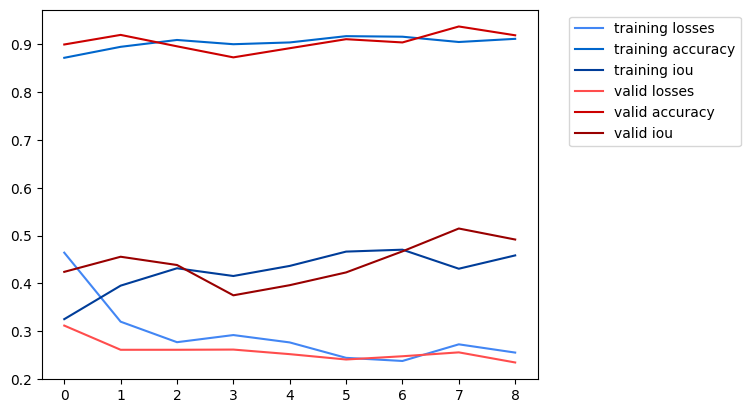

None

max valid iou: tensor(0.5148, device='cuda:0')


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
import os
from IPython.display import display
import matplotlib.pyplot as plt

max_valid_iou = 0
start = 0

epochs = []
training_losses = []
training_accuracies = []
training_ious = []
valid_losses = []
valid_accuracies = []
valid_ious = []

for i in range(start, 1000):
  train_validation_loop(net, optimizer, scheduler, train_loader, valid_loader, 10, i)
  epochs.append(i)
  x = epochs

  # plt.plot(x, training_losses.cpu(), label='training losses')
  # plt.plot(x, training_accuracies, 'tab:orange', label='training accuracy')
  # plt.plot(x, training_ious, 'tab:purple', label='training iou')
  # plt.plot(x, valid_losses, label='valid losses')
  # plt.plot(x, valid_accuracies, 'tab:red',label='valid accuracy')
  # plt.plot(x, valid_ious, 'tab:green',label='valid iou')
  # plt.legend(loc="upper left")

  plt.plot(x, [l.detach().cpu().numpy() for l in training_losses], label='training losses', color = "#4286f4")
  plt.plot(x, [a.detach().cpu().numpy() for a in training_accuracies], label='training accuracy', color = "#0066cc")
  plt.plot(x, [iou.detach().cpu().numpy() for iou in training_ious], label='training iou', color = "#003d99")
  plt.plot(x, [l.detach().cpu().numpy() for l in valid_losses], label='valid losses', color = "#ff4d4d")
  plt.plot(x, [a.detach().cpu().numpy() for a in valid_accuracies],label='valid accuracy', color = "#cc0000")
  plt.plot(x, [iou.detach().cpu().numpy() for iou in valid_ious],label='valid iou', color = "#990000")
  plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

  display(plt.show())

  print("max valid iou:", max_valid_iou)